from [here](https://github.com/pytorch/examples/blob/master/mnist/main.py)

- change dataset, MNIST is too easy
- todo try to adjust and understand conv layer

In [1]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms

%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [7]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.FashionMNIST(root='./data', train=False, download=False, transform=transform)
data_loader_train = DataLoader(mnist_trainset, 64, shuffle=True, num_workers=8)
data_loader_test = DataLoader(mnist_testset, 64, shuffle=True, num_workers=8)

In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1:      torch.Size([64, 20, 24, 24])
        x = F.max_pool2d(x, 2, 2) # max_pool2d: torch.Size([64, 20, 12, 12])
        x = F.relu(self.conv2(x)) # conv2:      torch.Size([64, 50, 8, 8])
        x = F.max_pool2d(x, 2, 2) # max_pool2d: torch.Size([64, 50, 4, 4])
        x = x.view(-1, 4*4*50)    # flatten:    torch.Size([64, 800])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    
    def name(self):
        return "LeNet"
model = LeNet().to(device)
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0) #weight_decay (L2 regularization) makes thing worse

In [10]:
def get_num_correct(output, target):
    # max of dimension 1, keepdim, and [0] is value / [1] is index (we need only index)
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.view_as(pred)).sum().item()
    return correct

In [84]:
losses = []
def train(epoch):
    model.train()
    for i, (data, target) in enumerate(data_loader_train):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(f'epoch: {epoch}, i: {i}, loss: {loss.item()}')
            losses.append(loss.item())
            
        if i == len(data_loader_train)-1:
            correct = get_num_correct(output, target)
            print(f'training set last batch acc: {100. * correct / data.shape[0]}')
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss, default is mean
            correct += get_num_correct(output, target)
    test_loss /= len(data_loader_test.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_loader_test.dataset),
        100. * correct / len(data_loader_test.dataset)))

### Train

epoch: 0, i: 0, loss: 2.293252468109131
epoch: 0, i: 100, loss: 0.0666375681757927
epoch: 0, i: 200, loss: 0.015951722860336304
epoch: 0, i: 300, loss: 0.07768566161394119
epoch: 0, i: 400, loss: 0.1630481481552124
epoch: 0, i: 500, loss: 0.04356107488274574
epoch: 0, i: 600, loss: 0.04158174991607666
epoch: 0, i: 700, loss: 0.02045675367116928
epoch: 0, i: 800, loss: 0.004636809229850769
epoch: 0, i: 900, loss: 0.032663024961948395
training set last batch acc: 96.875

Test set: Average loss: 0.0446, Accuracy: 9846/10000 (98.46%)

epoch: 1, i: 0, loss: 0.00787893682718277
epoch: 1, i: 100, loss: 0.006622180342674255
epoch: 1, i: 200, loss: 0.012585222721099854
epoch: 1, i: 300, loss: 0.0023989006876945496
epoch: 1, i: 400, loss: 0.00792037695646286
epoch: 1, i: 500, loss: 0.019557740539312363
epoch: 1, i: 600, loss: 0.07443836331367493
epoch: 1, i: 700, loss: 0.0670129656791687
epoch: 1, i: 800, loss: 0.1430397927761078
epoch: 1, i: 900, loss: 0.006209813058376312
training set last bat

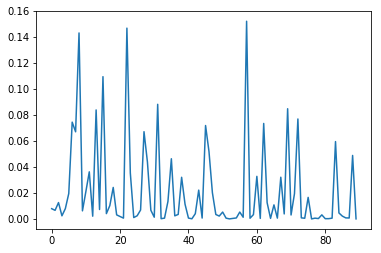

In [53]:
for epoch in range(10):
    train(epoch)
    test(epoch)

losses = losses[10:]
x_data = [i for i in range(len(losses))]
plt.plot(x_data, losses)